# **Stable Diffusion** 🎨
*...using '🧨diffusers'*

Stable Diffusionは、[CompVis](https://github.com/CompVis)、[Stability AI](https://stability.ai/)、[LAION](https://laion.ai/)の研究者やエンジニアが開発したtext-to-imageのdiffusion modelです。[LAION-5B](https://laion.ai/blog/laion-5b/)データベースのサブセットの512x512の画像で学習しています。このモデルは圧縮されたCLIP ViT-L/14テキストエンコーダーを使用し、文字入力からモデルを条件付けます。860MのUNetと123Mのテキストエンコーダを持つこのモデルは、比較的軽量で、多くの個人向けGPUで動作します。詳しくは[model card](https://huggingface.co/CompVis/stable-diffusion)をご覧ください。

このノートブックでは、🤗Hugging Face[🧨Diffusers library](https://github.com/huggingface/diffusers)を使って、Stable Diffusionを使用する方法を紹介します。

それでは始めてみましょう。

## 1. `StableDiffusionPipeline`の使い方

StableDiffusionがどのように動作するのか説明する前に、少し動かしてみましょう🤗。

このセクションでは、簡単にテキストから画像の推論をする方法をご紹介します。

### 前準備

はじめに、このノートブックにGPUが使用されているか確認してください。推論がより速くなります。

In [1]:
!nvidia-smi

Fri Apr 28 14:00:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.40       Driver Version: 517.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8    11W /  N/A |    250MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

次に、`diffusers`、`scipy`、`ftfy`、`transformers`をインストールします。`accelerate`はロード時間の短縮に用いられます。

In [2]:
!python -m pip install diffusers==0.11.1
!python -m pip install transformers scipy ftfy accelerate


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!python -m pip install --upgrade pip

     ---------------------------------------- 2.1/2.1 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1
    Uninstalling pip-23.1:
      Successfully uninstalled pip-23.1


### Stable Diffusion Pipeline

`StableDiffusionPipeline`はend-to-endの推論パイプラインで、テキストから画像を簡単に生成するために用いられます。

まず、モデル中のすべてのコンポーネントの事前学習済みの重みをロードします。このノートブックでは、Stable Diffusion バージョン1.4([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4))を使用します。他にもバリエーションがあるので、ぜひお試しください。

* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1) このバージョンは768x768の画像を生成しますが、他のバージョンは512x512で動作します。

モデルID[CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)に加えて、`from_pretrained`にも特定の`revision`と`torch_dtype`を渡しています。

無料版のGoogle Colab上でもStable Diffusionを実行できるようにしたいので、班制度ブランチからウェイトをロードしています。[`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16)を使用し、`torch_dtype=torch.float16`を渡すことで、float16精度の重みを期待するようにディフューザーに伝えます。

可能な限り高い精度を確保したい場合は、メモリ使用量が増えることを覚悟のうえで、`torch_dtype=torch.float16`を削除してください。

In [4]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


次に、パイプラインをGPUに移して、インターフェイスを高速化しましょう。

In [5]:
pipe = pipe.to("cuda")

画像を生成するための準備が整いました。

  0%|          | 0/50 [00:00<?, ?it/s]

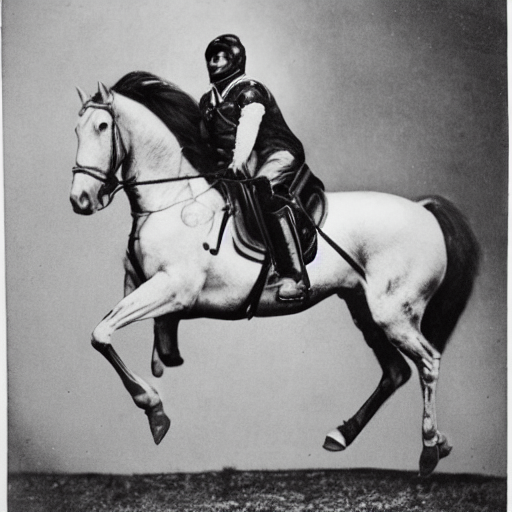

In [6]:
prompt = "a phoyograph of an astronaut riding a horse"
image = pipe(prompt).images[0]

image.save(f"astronaut_rides_horse.png")

image

上記のセルを複数回実行すると、毎回異なる画像が出力されます。出力が変化することが望ましくない場合、パイプラインにseed値を渡すことができます。同じseedを使うことで、同じ画像が出力されます。

  0%|          | 0/50 [00:00<?, ?it/s]

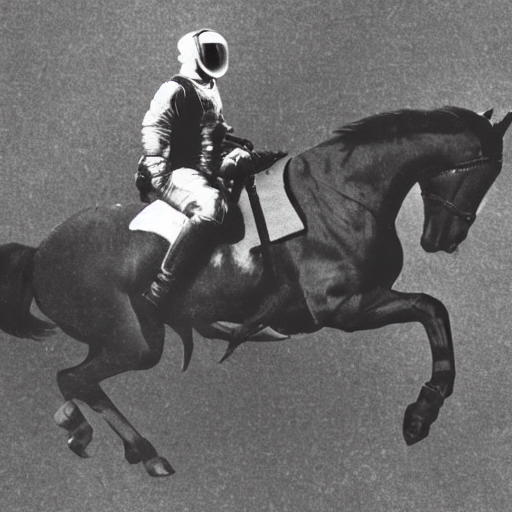

In [7]:
import torch

generator = torch.Generator("cuda").manual_seed(1024)

image = pipe(prompt, generator=generator).images[0]

image

引数`num_inference_steps`を使って推論ステップ数を変更することができます。一般的に、ステップ数が多いほど結果はよくなります。Stable Diffusionは最新のモデルの1つであり、比較的少ないステップ数でもうまく機能するため、デフォルトの50を使用することをお勧めします。もしより速く結果を得たいのであれば、より小さな数字を指定しましょう。

次のセルは、前と同じシードを使用していますが、より少ないステップ数です。馬の頭やヘルメットのような細部は、前の画像と比べて明確に表現されていないことに注意してください。

  0%|          | 0/15 [00:00<?, ?it/s]

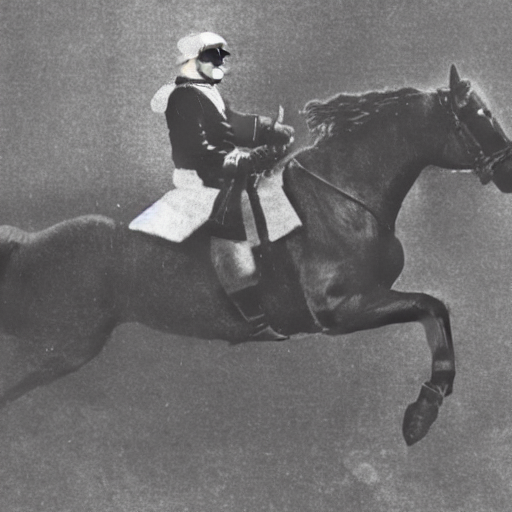

In [8]:
import torch

generator = torch.Generator("cuda").manual_seed(1024)

image = pipe(prompt, num_inference_steps=15, generator=generator).images[0]

image

パイプラインコールのもう一つのパラメータは`guidance_scale`です。これは、条件付信号（今回はテキスト）及び全体的なサンプルの品質への準拠を高めるための方法です。簡単に言うと、分類氏を使わないガイダンスは、よりプロンプトにマッチするように生成を強制します。`7`や`8.5`のような数字は良い結果をもたらしますが、非常に大きな数字を使用した場合、画像はよく見えるかもしれませんが、多様性に欠けることになります。

このパラメータの技術的な詳細についてはこのノートブックの[最後のセクション](https://colab.research.google.com/drive/1ALXuCM5iNnJDNW5vqBm5lCtUQtZJHN2f?authuser=1#scrollTo=UZp-ynZLrS-S)で説明します。

同じプロンプトに対して複数の画像を生成するには、同じプロンプトを複数回繰り返したリストを使用するだけです。先ほど使った文字列の代わりに、このリストをパイプラインに送ります。

まず、関数のグリッドを表示するためのヘルパー関数を書いてみましょう。以下のセルを実行すると`image_grid`関数が作成されます。どのように行われているか興味がある方はコードを精読してください。

In [9]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

これで、3つのプロンプトのリストでパイプラインを実行すれば、グリッド画像が生成できるようになりました。

In [ ]:
num_images = 3
prompt = ["a photograph of an astronaut riding a horse"] * num_images

images = pipe(prompt).images

grid = image_grid(images, rows=1, cols=3)
grid

`n × m`の画像を出力するには次のようにします。

In [ ]:
num_cols = 3
num_rows = 4

prompt = ["a photograph of an astronaut riding a horse"] * num_cols

all_images = []
for i in range(num_rows):
    images = pipe(prompt).images
    all_images.extend(images)

grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

### 正方形でない画像の生成

Stable Diffusionは、デフォルトで`512x512`ピクセルの画像を作成します。しかし、`height`や`width`の引数を使って、長方形の画像を作成することもできます。

以下は、適切なサイズを選択するためのいくつかの推奨事項です。
- `height`と`width`がともに`8`の倍数であることを確認してください。
- 512を下回ると、低品質の画像になる可能性があります。
- 縦横共に512を超えると、画像領域が繰り返されます（全体的なまとまりが失われます）。
- 長方形の画像を作成するときは、1つの次元に`512`を、もう1つの次元にそれよりも大きな値を使用するのが効果的です。

  0%|          | 0/50 [00:00<?, ?it/s]

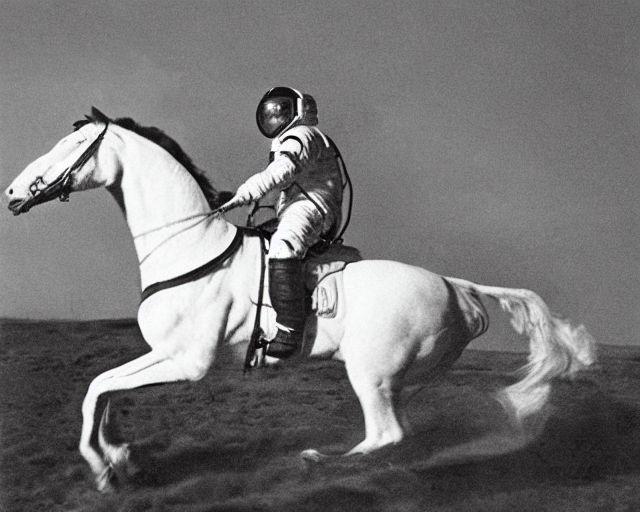

In [11]:
prompt = "a photograph of an astronaut riding a horse"

image = pipe(prompt, height=512, width=640).images[0]
image

## 2. Stable Diffusionとは

さて、Stable Diffusion👩‍🎓の論理的な部分について説明します。

Stable Diffusionは、[High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752)で提案された**Latent Diffusion**という特殊なDiffusionモデルに基づいています。

一般的なDiffusionモデルは、ランダムなガウシアンノイズを段階的に除去するように訓練された機械学習システムで、画像などの目的のサンプルに到達するために使用されます。より詳細な仕組みについては、こちらの[Colab](https://colab/research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb)をご覧ください。

Diffusionモデルは、画像データの生成において、最先端の結果を達成することが示されています。しかし、Diffusionモデルの欠点は、逆ノイズ処理に時間がかかることです。また、これらのモデルはピクセル空間で動作するため、多くのメモリを消費し、高解像度の画像を生成する場合には不当に高価になります。そのため、これらのモデルを訓練し、さらに推論に使用することは困難です。



<br>

Latent Diffusionは、実際にピクセル空間を使用する代わりに、低次元の潜在空間上で拡散プロセスを適用することにより、メモリと計算の複雑さを軽減することができます。これが標準的なDiffusionモデルとLatent Diffusionモデルの主な違いです。**Latent Diffusionでは、モデルは画像の潜伏（圧縮）表現を生成するように訓練されます。**

Latent Diffusionについては、3つの主なコンポーネントがあります。

1. オートエンコーダ（VAE）
2. [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq)
3. テキストエンコーダ（[CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel)など）

**1. オートエンコーダ (VAE)**

VAEモデルはエンコーダとデコーダの二つの部分があります。エンコーダは画像を低次元の潜在表現に変換し、U-Netの入力として使用されます。デコーダは、逆に潜在表現を画像に変換します。

LatentDiffusionでは、エンコーダは各ステップでより多くのノイズを適用する順拡散プロセスのために、画像の潜在表現を得るために使用されます。推論では、逆拡散処理で生成された潜在表現を、デコーダを用いて画像に戻します。後述するように、推論時に必要なのはVAEデコーダのみです。

**2. U-Net**

U-NetはResNetブロックで構成されたエンコーダとデコーダでできています。
エンコーダは画像を低解像度に圧縮し、デコーダは低解像度表現をノイズが除去された高解像度表現に復元します。
具体的には、U-Netの出力は、ノイズの除去された画像を推論するために使用するノイズ残差を予測します。

U-Netがダウンサンプリング中に重要な情報を失うのを防ぐため、通常、エンコーダのダウンサンプリングResNetとデコーダのアップサンプリングResNetの間にショートカットが接続されます。
さらに、StableDiffusion U-Netは、相互アテンション層を介して、text-embeddingに出力を条件づけることができる。相互アテンション層は、U-Netのエンコーダとデコーダの両方に、通常ResNetブロックの間に追加されます。

**3. テキストエンコーダ**

テキストエンコーダは、入力されたプロンプト、例えば「An astronout riding a horse」をU-Netが理解できるように変換する役割を担っています。これは通常、入力トークンシーケンスを潜在的なテキスト埋め込みシーケンスにマッピングする単純な変換器ベースのエンコーダです。

[Imagen](https://imagen.research.google/)に影響されたStableDiffusionは、学習中にテキストエンコーダを訓練せず、単にCLIPの訓練済みテキストエンコーダ、[CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel)を使用しています。

**なぜLatentDiffusionは高速で効率的なのか**

**推論中のStableDiffusion**

<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500">



- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default).
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Heun Discrete scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete).
- [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py).

In [12]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.12.mlp.fc1.bias', 'vision_model.encoder.layers.4.layer_norm2.weight', 'vision_model.encoder.layers.2.layer_norm2.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.21.layer_norm2.weight', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.15.layer_norm1.weight', 'vision_model.encoder.layers.20.self_attn.q_proj.weight', 'vision_model.encoder.layers.16.mlp.fc2.bias', 'vision_model.encoder.layers.12.mlp.fc2.weight', 'vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.self_attn.k_proj.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.15.self_attn.out_proj.weight', 'vision_model.encoder

In [ ]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [ ]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

In [ ]:
latents.shape

In [ ]:
scheduler.set_timesteps(num_inference_steps)

In [ ]:
latents = latents * scheduler.init_noise_sigma

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]